# Table Aggregation

In this notebook we aggregate the raw data into tables as used in our figures.

In [3]:
import numpy as np

In [4]:
import pandas as pd

def aggregate(df):
    best_of_10 = df.groupby(["sample_id"]).max()
    best_of_10["num_full_match"] = (best_of_10["consistency"] == 1.0)
    res = best_of_10.groupby(["num_nodes", "num_networks"]).mean()
    res["num_full_match"] = best_of_10.groupby(["num_nodes","num_networks"]).sum()["num_full_match"]
    return res

def aggregate_3pred(df, consistency_column="overall"):
    best_of_10 = df.groupby(["sample_id"]).max()
    best_of_10["num_full_match"] = (best_of_10["overall"] == 1.0)
    best_of_10["num_close_match"] = (best_of_10["overall"] > 0.95)
    best_of_10["num_close_match90"] = (best_of_10["overall"] > 0.9)
    best_of_10["num_full_fwd"] = (best_of_10["fwd"] == 1.0)
    best_of_10["num_reachable"] = (best_of_10["reachable"] == 1.0) # np.logical_and((best_of_10["fwd"] == 1.0).values, (best_of_10["reachable"] == 1.0).values)
    best_of_10["num_trafficIsolation"] = (best_of_10["trafficIsolation"] == 1.0) # np.logical_and((best_of_10["fwd"] == 1.0).values, (best_of_10["reachable"] == 1.0).values)
    res = best_of_10.groupby(["num_nodes", "num_networks"]).mean()
    res["num_full_match"] = best_of_10.groupby(["num_nodes","num_networks"]).sum()["num_full_match"]
    res["num_full_fwd"] = best_of_10.groupby(["num_nodes","num_networks"]).sum()["num_full_fwd"]
    res["num_reachable"] = best_of_10.groupby(["num_nodes","num_networks"]).sum()["num_reachable"]
    res["num_trafficIsolation"] = best_of_10.groupby(["num_nodes","num_networks"]).sum()["num_trafficIsolation"]
    res["num_close_match"] = best_of_10.groupby(["num_nodes","num_networks"]).sum()["num_close_match"]
    res["num_close_match90"] = best_of_10.groupby(["num_nodes","num_networks"]).sum()["num_close_match90"]
    return res

In [5]:
def aggregate_paper(df, consistency_column="overall", aggregate_by_n=False):
    best_of_10 = df.groupby(["sample_id"]).max()
    best_of_10["num_full_match"] = (best_of_10["overall"] == 1.0)
    best_of_10["num_close_match"] = (best_of_10["overall"] > 0.95)
    best_of_10["num_close_match90"] = (best_of_10["overall"] > 0.9)
    best_of_10["num_full_fwd"] = (best_of_10["fwd"] == 1.0)
    best_of_10["num_reachable"] = (best_of_10["reachable"] == 1.0) # np.logical_and((best_of_10["fwd"] == 1.0).values, (best_of_10["reachable"] == 1.0).values)
    best_of_10["num_trafficIsolation"] = (best_of_10["trafficIsolation"] == 1.0) # np.logical_and((best_of_10["fwd"] == 1.0).values, (best_of_10["reachable"] == 1.0).values)
    
    num_nodes_values = list(sorted(best_of_10["num_nodes"].values))
    if len(num_nodes_values) / 3 != int(len(num_nodes_values) / 3):
        print("warning: provided samples cannot be evenly distributed into 3 datasets small/medium/large")
    first_boundary = int(len(num_nodes_values) / 3)
    second_boundary = int(len(num_nodes_values) * 2 / 3)
    # print("first_boundary:", num_nodes_values[first_boundary - 1])
    # print("second_boundary:", num_nodes_values[second_boundary - 1])
    # print("third_boundary:", num_nodes_values[-1])
    # print(num_nodes_values)

    best_of_10["group"] = pd.cut(best_of_10["num_nodes"], [0,18,39,153])
    assert all([v == 8 for v in best_of_10.groupby("group").count()["overall"].values]), "The provided samples cannot distributed into three datasets of equal size 8 with num_nodes boundaries [0, 18, 39, 153]: Instead got num_nodes values {}".format(num_nodes_values)
    res = best_of_10.groupby("group").mean()

    res["num_full_match"] = best_of_10.groupby("group").sum()["num_full_match"]
    res["num_full_fwd"] = best_of_10.groupby("group").sum()["num_full_fwd"]
    res["num_reachable"] = best_of_10.groupby("group").sum()["num_reachable"]
    res["num_trafficIsolation"] = best_of_10.groupby("group").sum()["num_trafficIsolation"]
    res["num_close_match"] = best_of_10.groupby("group").sum()["num_close_match"]
    res["num_close_match90"] = best_of_10.groupby("group").sum()["num_close_match90"]
    return res
    
def to_latex_paper(df):
    #print(to_latex(df))
    lines = []
    for row in df.iloc:
        def group_name(g): return "Small" if g == 0 else ("Medium" if g == 1 else "Large")
        group = group_name(row["num_nodes"])
        columns = [
            group,
            "%.2f" % row["fwd"],
            "%.2f" % row["reachable"],
            "%.2f" % row["trafficIsolation"],
            "\\textbf{%.2f}" % row["overall"],
            "%.2f" % (row["num_full_match"] / 8),
            "%.2f" % (row["num_close_match90"] / 8),
        ]
        lines.append("& " + " & ".join(columns) + "\\\\")
    return "\n".join(lines)

In [6]:
f = "results-eval-64-bgp-reqs-16-4shot-manysamples-10235.pkl-results.pkl"
df = pd.read_pickle(f).reset_index()

In [7]:
def collect_results_up_to(df, i):
    res = {}
    counts = {}
    num_samples = 0
    
    for row in df.iloc:
        num_samples += 1
        k = (row["sample_id"], row["num_nodes"])
        if not k in counts: 
            counts[k] = 0
            res[k] = 0
        if counts[k] > i - 1:
            continue
        counts[k] += 1
        res[k] = max(res[k], row["overall"])
    ids = sorted(list(res.keys()))

    dataset_avg = {
        "Small": 0,
        "Medium": 0,
        "Large": 0
    }
    dataset_cnt = {
        "Small": 0,
        "Medium": 0,
        "Large": 0
    }
    
    buckets = [0,18,39,153]
    
    for id,num_nodes in ids:
        d = ""
        if num_nodes <= buckets[1]:
            d = "Small"
        elif num_nodes <= buckets[2]:
            d = "Medium"
        else:
            d = "Large"
        dataset_avg[d] += res[(id,num_nodes)]
        dataset_cnt[d] += 1
    
    num_samples_per_dataset = list(dataset_cnt.values())[0]
    assert all([v == num_samples_per_dataset for v in dataset_cnt.values()]), "Each dataset should have the same number of samples, not {}".format(dataset_cnt)

    return [v / 8 for d,v in dataset_avg.items()]

x = []
y_small = []
y_medium = []
y_large = []

for i in range(1, 21):
    s,m,l = collect_results_up_to(df, i)
    x.append(i)
    y_small.append(s)
    y_medium.append(m)
    y_large.append(l)


In [8]:
y_small = np.array(y_small)
y_medium = np.array(y_medium)
y_large = np.array(y_large)

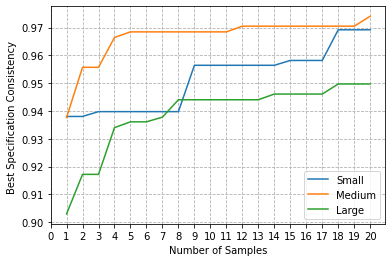

In [9]:
import matplotlib.pyplot as plt
import numpy as np
# import tikzplotlib

plt.plot(x, y_small, label="Small")
plt.plot(x, y_medium, label="Medium")
plt.plot(x, y_large, label="Large")

# plt.plot(x, (y_small - y_small.min()) / (y_small.max() - y_small.min()), label="Small")
# plt.plot(x, (y_medium - y_medium.min()) / (y_medium.max() - y_medium.min()), label="Medium")
# plt.plot(x, (y_large - y_large.min()) / (y_large.max() - y_large.min()), label="Large")

plt.grid(True,which="both", linestyle='--')
#plt.ylim(0.0,1.1)
plt.ylabel("Best Specification Consistency ")
plt.xlabel("Number of Samples")
plt.xticks(range(0,21))
plt.legend()
# tikzplotlib.save("test.tex")
# !cat test.tex

In [11]:
df.groupby(["sample_id"]).max()["overall"]

sample_id
0     0.918033
1     1.000000
2     1.000000
3     0.951613
4     0.921875
5     0.869565
6     1.000000
7     0.890625
8     0.945455
9     0.980769
10    0.933333
11    1.000000
12    0.958333
13    0.984615
14    1.000000
15    1.000000
16    0.945946
17    0.868852
18    0.887324
19    0.814286
20    0.983871
21    0.928571
22    1.000000
23    0.844444
Name: overall, dtype: float64